# Task Selection for  MTEB(eng, lite)

This is intended for creating mteb lite.


In [1]:
from __future__ import annotations

import mteb

print(mteb.__version__)

/Users/au561649/.virtualenvs/mteb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.48


## Defining the Tasks
Here we define the tasks for MTEB(eng, v2)

In [2]:
from mteb.benchmarks import MTEB_MAIN_EN

tasks = mteb.get_tasks(tasks=MTEB_MAIN_EN.tasks)


# get the updated version of tasks, which uses the new implementation (typically notably faster, but SummEvalSummarization.v2 also contains a notable bug fix: https://github.com/embeddings-benchmark/mteb/issues/1156
new_tasks = []
for task in tasks:
    if task.superseded_by is not None:
        print(f"Task {task.metadata.name} -> {task.superseded_by}")
        new_tasks.append(task.superseded_by)
    else:
        new_tasks.append(task.metadata.name)

tasks = mteb.get_tasks(tasks=new_tasks)

# Remove tasks based on discussion on quality and use as training data. See e.g.: https://github.com/embeddings-benchmark/mteb/issues/1050
# The intention is to make the dataset a zero-shot evaluation dataset
tasks = [t for t in tasks if t.metadata.name not in ["QuoraRetrieval", "MSMARCO", "NQ"]]

Task ArxivClusteringP2P -> ArXivHierarchicalClusteringP2P
Task ArxivClusteringS2S -> ArXivHierarchicalClusteringS2S
Task BiorxivClusteringP2P -> BiorxivClusteringP2P.v2
Task BiorxivClusteringS2S -> BiorxivClusteringS2S.v2
Task MedrxivClusteringP2P -> MedrxivClusteringP2P.v2
Task MedrxivClusteringS2S -> MedrxivClusteringS2S.v2
Task RedditClustering -> RedditClustering.v2
Task RedditClusteringP2P -> RedditClusteringP2P.v2
Task STS22 -> STS22.v2
Task StackExchangeClustering -> StackExchangeClustering.v2
Task StackExchangeClusteringP2P -> StackExchangeClusteringP2P.v2
Task SummEval -> SummEvalSummarization.v2
Task TwentyNewsgroupsClustering -> TwentyNewsgroupsClustering.v2


In [3]:
for task in tasks:
    print(task.metadata.name)

AmazonCounterfactualClassification
AmazonPolarityClassification
AmazonReviewsClassification
ArguAna
ArXivHierarchicalClusteringP2P
ArXivHierarchicalClusteringS2S
AskUbuntuDupQuestions
BIOSSES
Banking77Classification
BiorxivClusteringP2P.v2
BiorxivClusteringS2S.v2
CQADupstackAndroidRetrieval
CQADupstackEnglishRetrieval
CQADupstackGamingRetrieval
CQADupstackGisRetrieval
CQADupstackMathematicaRetrieval
CQADupstackPhysicsRetrieval
CQADupstackProgrammersRetrieval
CQADupstackStatsRetrieval
CQADupstackTexRetrieval
CQADupstackUnixRetrieval
CQADupstackWebmastersRetrieval
CQADupstackWordpressRetrieval
ClimateFEVER
DBPedia
EmotionClassification
FEVER
FiQA2018
HotpotQA
ImdbClassification
MTOPDomainClassification
MTOPIntentClassification
MassiveIntentClassification
MassiveScenarioClassification
MedrxivClusteringP2P.v2
MedrxivClusteringS2S.v2
MindSmallReranking
NFCorpus
RedditClustering.v2
RedditClusteringP2P.v2
SCIDOCS
SICK-R
STS12
STS13
STS14
STS15
STS16
STS17
STS22.v2
STSBenchmark
SciDocsRR
SciFa

## Loading in data
We will start out by loading in the relevant data for the model and tasks of interests.

In [4]:
def get_models():
    model_names = [
        "sentence-transformers/all-MiniLM-L6-v2",
        "sentence-transformers/all-MiniLM-L12-v2",
        "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        "sentence-transformers/all-mpnet-base-v2",
        "sentence-transformers/LaBSE",
        "intfloat/multilingual-e5-large-instruct",
        "intfloat/e5-mistral-7b-instruct",
        "GritLM/GritLM-7B",
        "GritLM/GritLM-8x7B",
        "intfloat/multilingual-e5-small",
        "intfloat/multilingual-e5-base",
        "intfloat/multilingual-e5-large",
    ]
    models: list[mteb.ModelMeta] = [mteb.get_model_meta(name) for name in model_names]

    # get missing revisions - Assuming we are using the latest revision
    for model in models:
        if model.revision is None:
            print(f"Getting revision for {model.name}")
            encoder = model.load_model()
            model.revision = encoder.model_card_data.base_model_revision  # type: ignore

    return models


models = get_models()

Getting revision for sentence-transformers/all-MiniLM-L12-v2
Getting revision for sentence-transformers/all-mpnet-base-v2


In [18]:
# load results from mteb/results repository
mteb_results = mteb.load_results(models=models, tasks=tasks, download_latest=False)

In [19]:
import mteb.task_selection as task_selection

results_df = task_selection.results_to_dataframe(mteb_results, drop_na=False)

In [57]:
_results_df = results_df.copy()
_results_df["Average"] = _results_df.mean(axis=1)
_results_df = _results_df.sort_values("Average", ascending=False)
_results_df = _results_df[
    ["Average"] + [col for col in _results_df.columns if col != "Average"]
]
_results_df = _results_df.reset_index().drop(["revision"], axis=1)
# remove column name "task"
_results_df.columns.name = None
# rename index to rank
_results_df.index.name = "Rank"
_results_df.round(3)

,model,Average,AmazonCounterfactualClassification,AmazonPolarityClassification,AmazonReviewsClassification,ArXivHierarchicalClusteringP2P,ArXivHierarchicalClusteringS2S,ArguAna,AskUbuntuDupQuestions,BIOSSES,...,StackExchangeClustering.v2,StackExchangeClusteringP2P.v2,StackOverflowDupQuestions,TRECCOVID,Touche2020,ToxicConversationsClassification,TweetSentimentExtractionClassification,TwentyNewsgroupsClustering.v2,TwitterSemEval2015,TwitterURLCorpus
Rank,,,,,,,,,,,,,,,,,,,,,
0,GritLM/GritLM-7B,0.633,0.792,0.966,0.556,0.598,0.623,0.632,0.674,0.863,...,0.681,0.438,0.559,0.743,0.278,0.688,0.663,0.573,0.811,0.874
1,intfloat/e5-mistral-7b-instruct,0.629,0.732,0.963,0.520,0.653,0.613,0.617,0.670,0.855,...,0.643,0.481,0.549,0.870,0.263,0.717,0.649,0.533,0.816,0.878
2,intfloat/multilingual-e5-large-instruct,0.615,0.681,0.962,0.508,0.625,0.613,0.585,0.644,0.875,...,0.600,0.461,0.525,0.825,0.274,0.668,0.592,0.507,0.798,0.867
3,intfloat/multilingual-e5-large,0.574,0.762,0.933,0.439,0.556,0.562,0.544,0.592,0.825,...,0.464,0.385,0.501,0.712,0.231,0.660,0.628,0.392,0.753,0.858
4,intfloat/multilingual-e5-base,0.557,0.743,0.918,0.425,0.567,0.561,0.442,0.593,0.851,...,0.446,0.389,0.497,0.695,0.215,0.643,0.628,0.358,0.722,0.855
5,sentence-transformers/all-mpnet-base-v2,0.541,0.622,0.671,0.268,0.615,0.565,0.465,0.659,0.804,...,0.448,0.403,0.520,0.513,0.199,0.611,0.550,0.501,0.739,0.851
6,intfloat/multilingual-e5-small,0.537,0.695,0.886,0.408,0.543,0.542,0.391,0.564,0.825,...,0.434,0.376,0.470,0.726,0.212,0.636,0.628,0.345,0.708,0.850
7,sentence-transformers/paraphrase-multilingual-...,0.527,0.729,0.764,0.386,0.553,0.552,0.489,0.602,0.763,...,0.462,0.382,0.468,0.379,0.174,0.656,0.590,0.452,0.688,0.853
8,sentence-transformers/all-MiniLM-L12-v2,0.523,0.624,0.630,0.264,0.574,0.551,0.471,0.641,0.836,...,0.447,0.389,0.515,0.508,0.172,0.633,0.542,0.470,0.700,0.848


## Comparing Scores with MTEB

In [88]:
scores = _results_df[["model", "Average"]].copy()
# add rank
scores["Rank"] = scores["Average"].rank(ascending=False)

In [89]:
import pandas as pd

mteb_scores = {
    "GritLM/GritLM-7B": 66.76,
    "intfloat/e5-mistral-7b-instruct": 66.63,
    "intfloat/multilingual-e5-large-instruct": 64.41,
    "intfloat/multilingual-e5-large": 60.89,
    "intfloat/multilingual-e5-base": 59.11,
    "sentence-transformers/all-mpnet-base-v2": 57.78,
    "intfloat/multilingual-e5-small": 57.04,
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2": 54.64,
    "sentence-transformers/all-MiniLM-L12-v2": 56.53,
    "sentence-transformers/all-MiniLM-L6-v2": 56.1,
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2": 52.45,
    "sentence-transformers/LaBSE": 45.21,
}
mteb_scores_df = pd.DataFrame(mteb_scores.items(), columns=["model", "Average"])
mteb_scores_df["Rank"] = mteb_scores_df["Average"].rank(ascending=False)

In [90]:
# merge
all_scores = pd.merge(
    mteb_scores_df, scores, on="model", how="outer", suffixes=("_v1", "_v2")
)
all_scores["Average_v2"] = all_scores["Average_v2"] * 100
all_scores

,model,Average_v1,Rank_v1,Average_v2,Rank_v2
0,GritLM/GritLM-7B,66.76,1.0,63.256300,1.0
1,intfloat/e5-mistral-7b-instruct,66.63,2.0,62.881090,2.0
2,intfloat/multilingual-e5-large-instruct,64.41,3.0,61.453870,3.0
3,intfloat/multilingual-e5-large,60.89,4.0,57.440855,4.0
4,intfloat/multilingual-e5-base,59.11,5.0,55.690921,5.0
5,sentence-transformers/all-mpnet-base-v2,57.78,6.0,54.122250,6.0
6,intfloat/multilingual-e5-small,57.04,7.0,53.699672,7.0
7,sentence-transformers/paraphrase-multilingual-...,54.64,10.0,52.654694,8.0
8,sentence-transformers/all-MiniLM-L12-v2,56.53,8.0,52.315120,9.0
9,sentence-transformers/all-MiniLM-L6-v2,56.10,9.0,51.958840,10.0


Text(0.5, 1.0, 'Pearson correlation: 0.99, p-value: 0.00\nSpearman correlation: 0.98, p-value: 0.00')

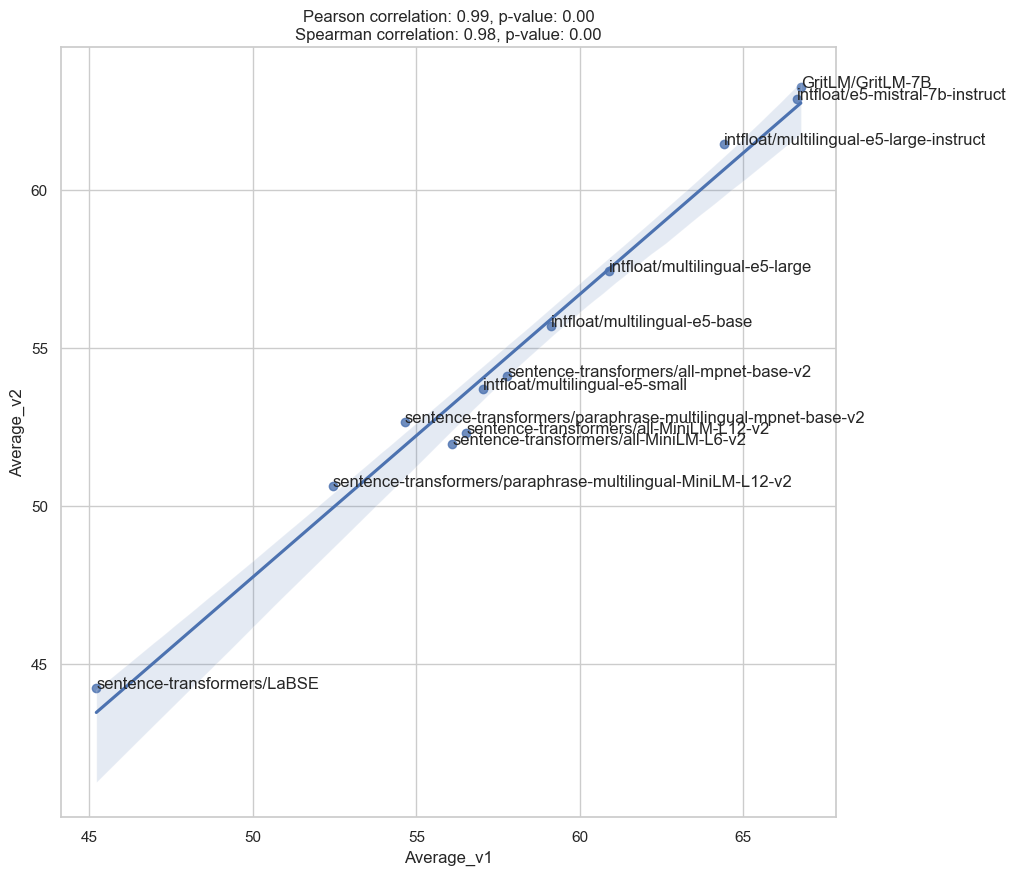

In [91]:
# correlation plot with model names, and a regression line
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
sns.regplot(x="Average_v1", y="Average_v2", data=all_scores)
for i, txt in enumerate(all_scores["model"]):
    plt.annotate(txt, (all_scores["Average_v1"][i], all_scores["Average_v2"][i]))

# add correlation coefficient

pearson_corr = pearsonr(all_scores["Average_v1"], all_scores["Average_v2"])
spearman_corr = spearmanr(all_scores["Average_v1"], all_scores["Average_v2"])

plt.title(
    f"Pearson correlation: {pearson_corr[0]:.2f}, p-value: {pearson_corr[1]:.2f}\nSpearman correlation: {spearman_corr[0]:.2f}, p-value: {spearman_corr[1]:.2f}"
)

# Task selection 
Here we do task selection for construction of MTEB(eng, v2, lite)

In [95]:
tasks_not_in_index = [
    "ClimateFEVER",
    "DBPedia",
    "FEVER",
    "HotpotQA",  # tasks which we will downsample (so will be included after the task selection)
    "SummEvalSummarization.v2",
]  # only summ task

In [96]:
def is_candidate_valid_removal(current_tasks: list[str], task_to_remove: str) -> bool:
    """Determine if target task should be removed.
    This checks that all task types are present in the current tasks
    """
    # check if removing task removes a unique task type - if so, don't remove
    _current_tasks = current_tasks.copy()
    if task_to_remove in _current_tasks:
        _current_tasks.remove(task_to_remove)
    task = mteb.get_task(task_to_remove)
    ctasks = mteb.get_tasks(tasks=_current_tasks)

    # don't remove a unique task type
    task_types = {t.metadata.type for t in ctasks}
    if task.metadata.type not in task_types:
        return False

    return True

In [102]:
from sklearn.linear_model import LinearRegression

# remove tasks one by one
tasks_to_select_from = [
    t.metadata.name for t in tasks if t.metadata.name not in tasks_not_in_index
]

tasks_removed = []
predicability_scores = []

while tasks_to_select_from:
    most_pred_tasks = task_selection.most_predictable_task(
        results_df[tasks_to_select_from],
        sklearn_estimator=LinearRegression(),
        metrics=[
            task_selection.spearman,
            task_selection.pearson,
            task_selection.mse_with_zscore,
        ],
    )

    # reverse the list to get the least predictable task
    most_pred_tasks.reverse()

    while most_pred_tasks:
        most_pred_task = most_pred_tasks.pop()
        most_pred_task_name = list(most_pred_task.keys())[0]

        # if the task is too hard to predict, skip it (this essentially stops the loop)
        if (
            most_pred_task[most_pred_task_name]["mse_with_zscore"] > 0.2
            or most_pred_task[most_pred_task_name]["spearman"] < 0.9
        ):
            continue

        if is_candidate_valid_removal(tasks_to_select_from, most_pred_task_name):
            tasks_to_select_from.remove(most_pred_task_name)
            tasks_removed.append(most_pred_task_name)
            predicability_scores.append(most_pred_task[most_pred_task_name])
            break

    if not most_pred_tasks:  # if no task was removed, then we are done -- can be replaced with another stopping criterion
        break

Task: TwitterURLCorpus: 100%|██████████| 28/28 [00:00<00:00, 73.51it/s]                      


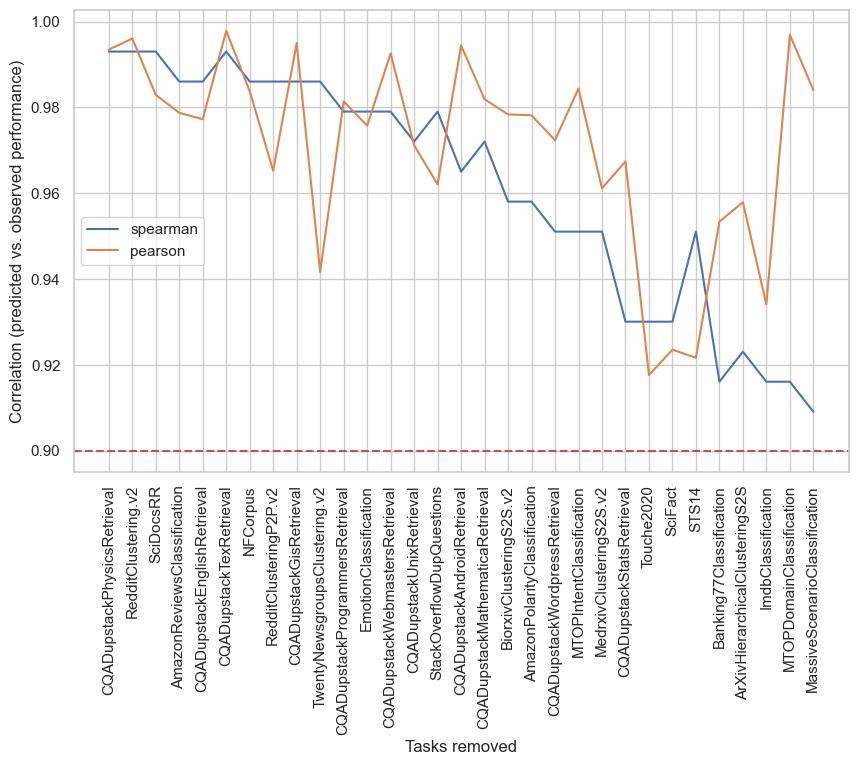

In [103]:
# plotting the predictability scores with the tasks removed
import matplotlib.pyplot as plt

# make the plot wider
plt.figure(figsize=(10, 6))

for metric in ["spearman", "pearson"]:
    plt.plot([t[metric] for t in predicability_scores], label=metric)

plt.xlabel("Tasks removed")
plt.ylabel("Correlation (predicted vs. observed performance)")
plt.legend()

# add vline for 0.9 spearman
plt.axhline(y=0.9, color="r", linestyle="--")

# add task names to the x-axis
plt.xticks(range(len(tasks_removed)), tasks_removed, rotation=90)
plt.show()

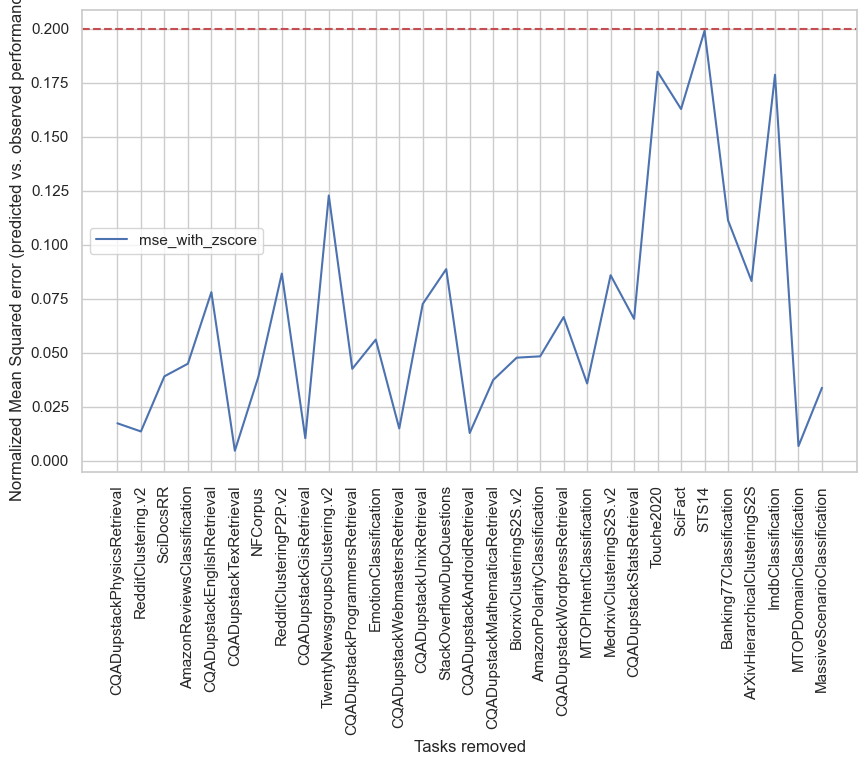

In [104]:
# plotting the predictability scores with the tasks removed

plt.figure(figsize=(10, 6))

for metric in ["mse_with_zscore"]:
    plt.plot([t[metric] for t in predicability_scores], label=metric)

plt.xlabel("Tasks removed")
plt.ylabel("Normalized Mean Squared error (predicted vs. observed performance)")
plt.legend()

# add vline for 0.2 mse
plt.axhline(y=0.2, color="r", linestyle="--")

# add task names to the x-axis
plt.xticks(range(len(tasks_removed)), tasks_removed, rotation=90)
plt.show()

In [108]:
# TODO: add the tasks in tasks_not_in_index back in

# Compare scores with scores prior to selection

In [115]:
scores_lite = results_df[tasks_to_select_from].copy()
scores_lite["Average"] = scores_lite.mean(axis=1)
scores_lite["Rank"] = scores_lite["Average"].rank(ascending=False)
scores_lite = scores_lite.reset_index().drop(["revision"], axis=1)

In [123]:
# merge and compare with the original scores

all_scores_lite = pd.merge(
    scores,
    scores_lite[["model", "Average", "Rank"]],
    on="model",
    how="outer",
    suffixes=("_v2_full", "_v2_lite"),
)

all_scores_lite.round(2)

,model,Average_v2_full,Rank_v2_full,Average_v2_lite,Rank_v2_lite
0,GritLM/GritLM-7B,0.63,1.0,0.69,2.0
1,intfloat/e5-mistral-7b-instruct,0.63,2.0,0.69,1.0
2,intfloat/multilingual-e5-large-instruct,0.61,3.0,0.68,3.0
3,intfloat/multilingual-e5-large,0.57,4.0,0.64,4.0
4,intfloat/multilingual-e5-base,0.56,5.0,0.63,5.0
5,sentence-transformers/all-mpnet-base-v2,0.54,6.0,0.60,8.0
6,intfloat/multilingual-e5-small,0.54,7.0,0.61,6.0
7,sentence-transformers/paraphrase-multilingual-...,0.53,8.0,0.60,7.0
8,sentence-transformers/all-MiniLM-L12-v2,0.52,9.0,0.58,10.0
9,sentence-transformers/all-MiniLM-L6-v2,0.52,10.0,0.58,11.0


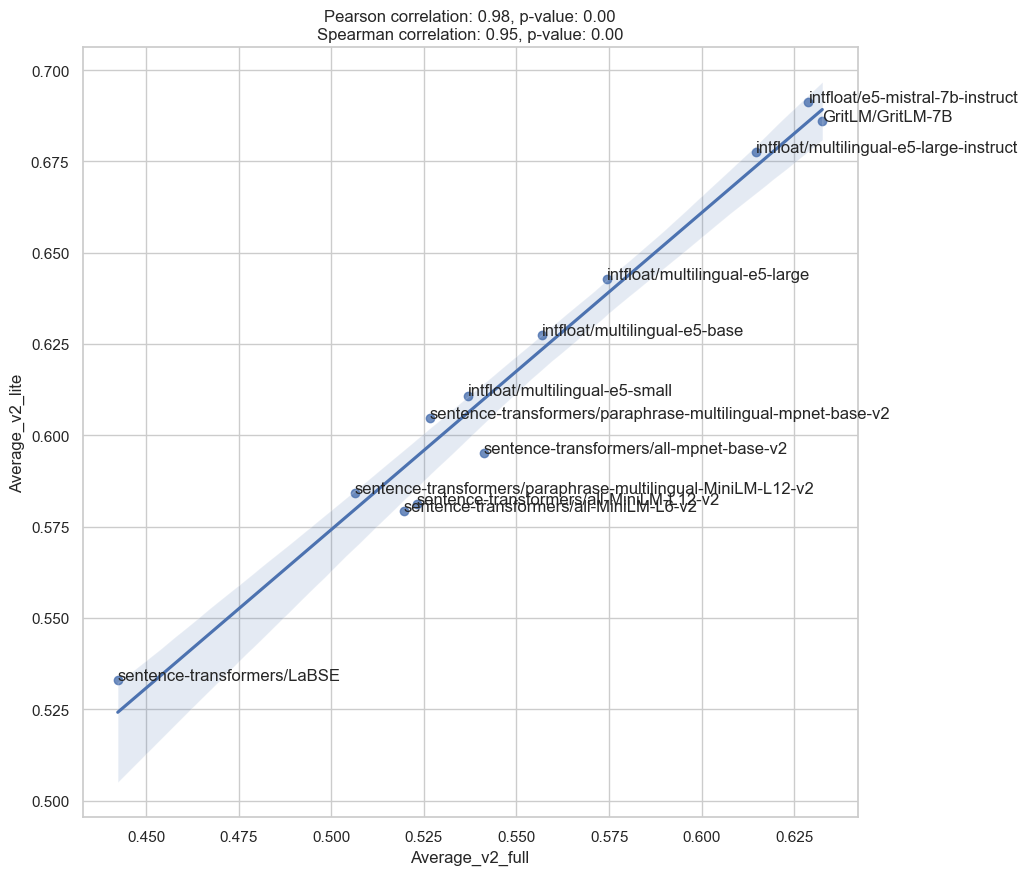

In [124]:
# correlation plot with model names, and a regression line

plt.figure(figsize=(10, 10))
sns.regplot(x="Average_v2_full", y="Average_v2_lite", data=all_scores_lite)
for i, txt in enumerate(all_scores_lite["model"]):
    plt.annotate(
        txt,
        (all_scores_lite["Average_v2_full"][i], all_scores_lite["Average_v2_lite"][i]),
    )

# add correlation coefficient

pearson_corr = pearsonr(
    all_scores_lite["Average_v2_full"], all_scores_lite["Average_v2_lite"]
)
spearman_corr = spearmanr(
    all_scores_lite["Average_v2_full"], all_scores_lite["Average_v2_lite"]
)

plt.title(
    f"Pearson correlation: {pearson_corr[0]:.2f}, p-value: {pearson_corr[1]:.2f}\nSpearman correlation: {spearman_corr[0]:.2f}, p-value: {spearman_corr[1]:.2f}"
)

plt.show()

In [126]:
# compare with v1

all_scores_v1 = pd.merge(
    all_scores_lite,
    mteb_scores_df,
    on="model",
    how="outer",
    suffixes=("_v2_lite", "_v1"),
)

all_scores_v1.round(2)

,model,Average_v2_full,Rank_v2_full,Average_v2_lite,Rank_v2_lite,Average,Rank
0,GritLM/GritLM-7B,0.63,1.0,0.69,2.0,66.76,1.0
1,intfloat/e5-mistral-7b-instruct,0.63,2.0,0.69,1.0,66.63,2.0
2,intfloat/multilingual-e5-large-instruct,0.61,3.0,0.68,3.0,64.41,3.0
3,intfloat/multilingual-e5-large,0.57,4.0,0.64,4.0,60.89,4.0
4,intfloat/multilingual-e5-base,0.56,5.0,0.63,5.0,59.11,5.0
5,sentence-transformers/all-mpnet-base-v2,0.54,6.0,0.60,8.0,57.78,6.0
6,intfloat/multilingual-e5-small,0.54,7.0,0.61,6.0,57.04,7.0
7,sentence-transformers/paraphrase-multilingual-...,0.53,8.0,0.60,7.0,54.64,10.0
8,sentence-transformers/all-MiniLM-L12-v2,0.52,9.0,0.58,10.0,56.53,8.0
9,sentence-transformers/all-MiniLM-L6-v2,0.52,10.0,0.58,11.0,56.10,9.0


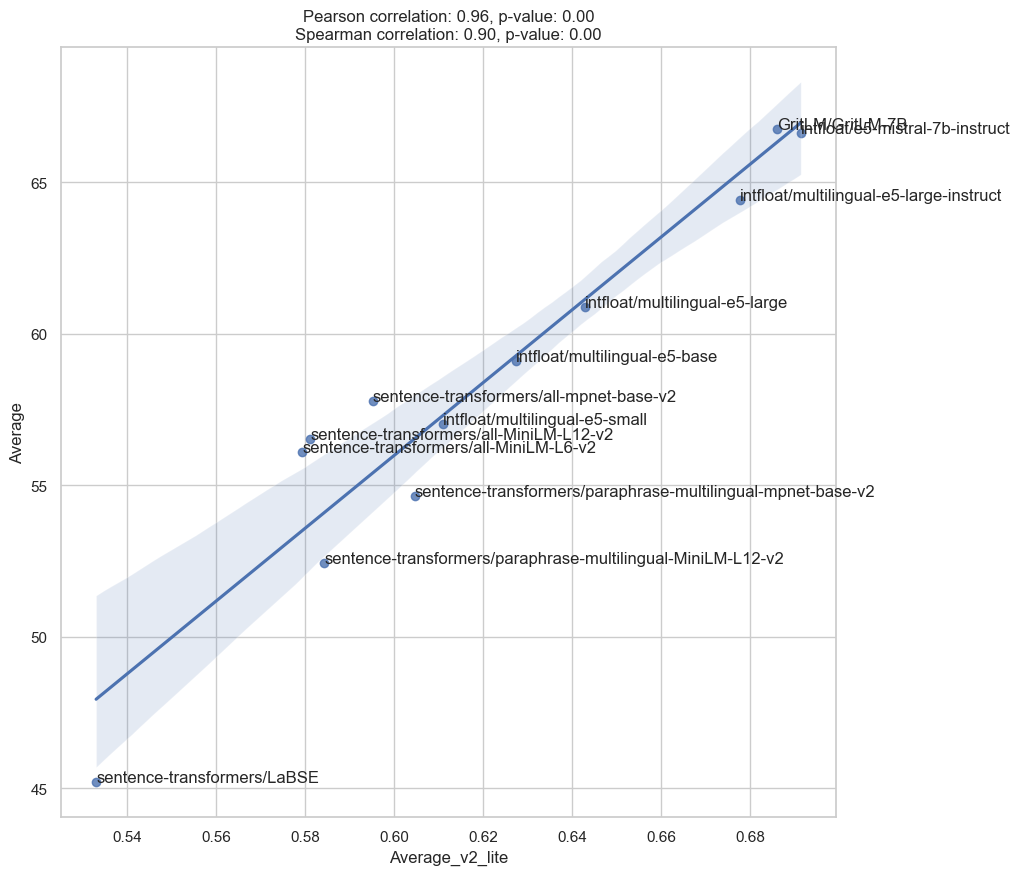

In [127]:
# correlation plot with model names, and a regression line

plt.figure(figsize=(10, 10))
sns.regplot(x="Average_v2_lite", y="Average", data=all_scores_v1)
for i, txt in enumerate(all_scores_v1["model"]):
    plt.annotate(
        txt, (all_scores_v1["Average_v2_lite"][i], all_scores_v1["Average"][i])
    )

# add correlation coefficient

pearson_corr = pearsonr(all_scores_v1["Average_v2_lite"], all_scores_v1["Average"])
spearman_corr = spearmanr(all_scores_v1["Average_v2_lite"], all_scores_v1["Average"])

plt.title(
    f"Pearson correlation: {pearson_corr[0]:.2f}, p-value: {pearson_corr[1]:.2f}\nSpearman correlation: {spearman_corr[0]:.2f}, p-value: {spearman_corr[1]:.2f}"
)

plt.show()